In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../src")

In [40]:
from CompoTree import ComponentTree, Radicals, TSVariants, CharLexicon, CTFounds
from gensim.models.keyedvectors import KeyedVectors
import numpy as np
import numpy.linalg as la
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
plt.rcParams["font.family"] = "HanaMinA" 

In [4]:
kv = KeyedVectors.load("../data/fasttext-zh-sw/fasttext-zh-sw.kv")
kv.init_sims()

In [69]:
ctree = ComponentTree.load()
radicals = Radicals.load()
tsvars = TSVariants.load()
lexicon = CharLexicon.load(topn=3000)

In [70]:
[(x, y) for x, y in ctree.mutual_friends("木", "火")
 if x in lexicon.traditional and y in lexicon.traditional]

[WARNING] current implementation only consider two-component characters with target at the first position


[('榕', '熔'),
 ('杜', '灶'),
 ('檜', '燴'),
 ('橙', '燈'),
 ('樺', '燁'),
 ('欄', '爛'),
 ('格', '烙'),
 ('杓', '灼'),
 ('楊', '煬'),
 ('棍', '焜'),
 ('柄', '炳'),
 ('桿', '焊')]

In [88]:
targets = "澄橙燈杆欄爛炒沙汗"
vectors = np.array(
          [5, 4,
           2, 8,
           7, 8,
           2.5, 9,
           1.5, 9,
           8.5, 5.5,
           8.5, 8.5,
           5.5, 1,
           2.5, 1])
vectors = np.reshape(vectors, (9, 2))

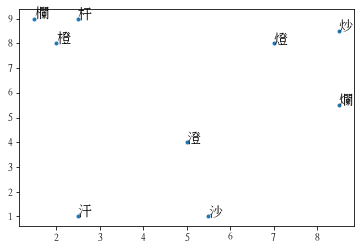

In [89]:
plt.plot(vectors[:,0], vectors[:, 1], '.')
for i, ch in enumerate(targets):
    plt.text(vectors[i, 0], vectors[i, 1], targets[i], fontsize=14)